#NEURAL NETWORKS AND DEEP LEARNING
# Homework 2
---
Elena Leonelli - mat.2028635 - M.Sc. Physics of data

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms

from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
from optuna.trial import TrialState

In this homework I implement and test an autoencoder for solving unsupervised problems. I start defining the AE, and training it to get the reconstruction loss. Then, I use OPTUNA for finding the best parameters.

I fine-tune the AE using a (supervised) classification task: the idea is that, in cases of noisy images for example, the AE part is able to denoise the input images, making them easier to classify. At the same time, fine-tuning the AE will make it more sensitive to the differences between classes.

After exploring the latent space, I implement and test a variational autoencoder.


# Dataset

## Define the dataset

The Dataset usef is the Fashion MNIST dataset, a colletion of Zalando's article images. The size of the images is $28 \times 28$, and there is a single channel only (black and white images) with 10 classes.

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



Transforming the input data to tensors of the proper shape.

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Validation split

In [ ]:
#divide in training (0.8) an validation (0.2) dataset

p = 0.8
n_train = int(len(train_dataset)*p) 
n_valid = len(train_dataset) - n_train

print("Elements in Train set:",      n_train)
print("Elements in Validation set:", n_valid)
print("Elements in Test set:",       len(test_dataset) )

# Prepare Training and Validation sets
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_valid])

Elements in Train set: 48000
Elements in Validation set: 12000
Elements in Test set: 10000


## Define the dataloader

In [ ]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define validation dataloader
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(validation_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=288),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

# Training

In [ ]:
### Define the loss function
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4
wd = 1e-5

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=wd)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()

    conc_out = []
    conc_label = []
    
    # Iterate the dataloader
    for image_batch, _ in dataloader:
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)

        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append the network output and the original image to the lists
        conc_out.append(decoded_data.cpu())
        conc_label.append(image_batch.cpu())
        
    # Create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label)
    
    # Evaluate global loss
    train_loss = loss_fn(conc_out, conc_label)  
    
    return train_loss.data



In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()

    with torch.no_grad():

        conc_out = []
        conc_label = []
        
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)

            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 

        # Evaluate global loss
        test_loss = loss_fn(conc_out, conc_label)

    return test_loss.data

In [ ]:
### Training loop

def training_ae(encoder,decoder,device,train_dataloader,val_dataloader,
                parameters,save_state=False):

  num_epochs = parameters['epochs']
  optim = parameters['optim']
  train_loss_tot = []
  val_loss_tot = []
  for epoch in tqdm(range(num_epochs)):
    
      ### Training (use the training function)
      train_loss = train_epoch(
          encoder=encoder, 
          decoder=decoder, 
          device=device, 
          dataloader=train_dataloader, 
          loss_fn=parameters['loss'], 
          optimizer=optim)
      
      ### Validation  (use the testing function)
      val_loss = test_epoch(
          encoder=encoder, 
          decoder=decoder, 
          device=device, 
          dataloader=val_dataloader, 
          loss_fn=parameters['loss'])

      train_loss_tot.append(train_loss)
      val_loss_tot.append(val_loss)


      if (save_state):
        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optimizer_params.pth')

  
  return train_loss_tot, val_loss_tot



In [ ]:
parameters = {'epochs': 40,
              'optim': optim,
              'loss': loss_fn}

In [ ]:
train_loss, val_loss = training_ae(encoder,decoder,device,train_dataloader,validation_dataloader, parameters, save_state=True)

100%|██████████| 40/40 [04:41<00:00,  7.03s/it]


## Reconstruction Loss

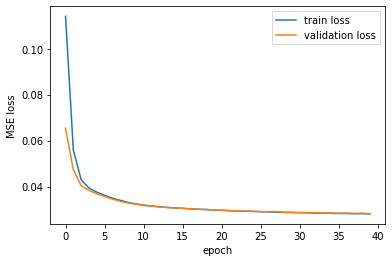

In [ ]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.show()

## Image reconstruction

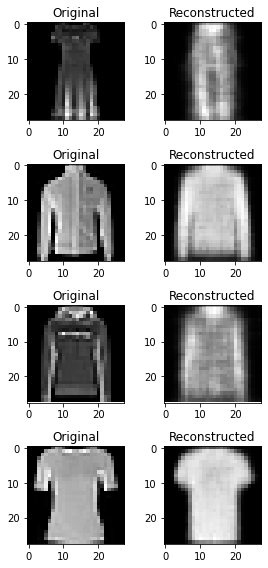

In [ ]:
## Examples of image reconstruction
fig, axs = plt.subplots(4, 2, figsize=(4,8))

for i in range(4):
  a=random.randint(1,10001)
  img, label = test_dataset[a]

  encoded_img  = encoder(img.unsqueeze(0).to(device))
  decoded_img  = decoder(encoded_img)

  axs[i,0].imshow(np.array(img[0]), cmap='gist_gray')
  axs[i,0].set_title('Original')
  axs[i,1].imshow(decoded_img.squeeze().cpu().detach().numpy(), cmap='gist_gray')
  axs[i,1].set_title('Reconstructed')

plt.tight_layout()

The images are not perfectly reconstructed, but they are somehow generalized with respect to the originals (i.e. the zip in the second input image is specific of that input, not generic: the reconstructed image has no zip. For the writing on the third input image is the same).

# Grid Search with OPTUNA

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
def define_model(trial):
    
    feature_dim = trial.suggest_int("encoded_space_dim", 2, 5)
    
    encoder = Encoder(encoded_space_dim=feature_dim)
    decoder = Decoder(encoded_space_dim=feature_dim)
    
    return nn.Sequential(encoder, decoder)

In [ ]:
def objective(trial,epochs=20):

    # Generate the model.
    model = define_model(trial).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3)
    wd = trial.suggest_float("wd", 5e-6, 5e-5)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd)
    

    # Get the FashionMNIST dataset.
    train_loader = train_dataloader
    valid_loader = validation_dataloader

    # Training of the model.
    for epoch in range(epochs):
        model.train()

        for image_batch, _ in train_loader:

            image_batch = image_batch.to(device)

            output = model(image_batch)
            loss = loss_fn(output, image_batch)
           
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        with torch.no_grad():
            conc_out = []
            conc_label = []
            for image_batch, _ in valid_loader:
              
                image_batch = image_batch.to(device)
                output = model(image_batch)

                # Append the network output and the original image to the lists
                conc_out.append(output.cpu())
                conc_label.append(image_batch.cpu())

            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
        
        trial.report(val_loss.data, epoch)
           
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss


In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()


In [ ]:
if __name__ == "__main__":
  
    study = optuna.create_study(direction="minimize",
                                pruner=optuna.pruners.MedianPruner(),
                                study_name     = 'autoencoder', 
                                storage        = 'sqlite:///autoencoder.db',
                                load_if_exists = True)
    
    study.optimize(objective, n_trials=50)


    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-07-01 16:54:35,261] A new study created in RDB with name: autoencoder
[I 2022-07-01 16:56:28,215] Trial 0 finished with value: 0.0249860230833292 and parameters: {'encoded_space_dim': 5, 'optimizer': 'RMSprop', 'lr': 0.0004325230561472179, 'wd': 1.7312469244661956e-05}. Best is trial 0 with value: 0.0249860230833292.
[I 2022-07-01 16:58:25,832] Trial 1 finished with value: 0.02195451408624649 and parameters: {'encoded_space_dim': 5, 'optimizer': 'Adam', 'lr': 0.0006480024310716308, 'wd': 7.575871663947725e-06}. Best is trial 1 with value: 0.02195451408624649.
[I 2022-07-01 17:00:16,345] Trial 2 finished with value: 0.026121245697140694 and parameters: {'encoded_space_dim': 4, 'optimizer': 'RMSprop', 'lr': 0.00041239666288974785, 'wd': 1.692416189518182e-05}. Best is trial 1 with value: 0.02195451408624649.
[I 2022-07-01 17:02:02,605] Trial 3 finished with value: 0.14637228846549988 and parameters: {'encoded_space_dim': 3, 'optimizer': 'SGD', 'lr': 0.0005630793591181756, 'wd': 3

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  30
  Number of complete trials:  20
Best trial:
  Value:  0.019457057118415833
  Params: 
    encoded_space_dim: 5
    lr: 0.0009997198923304752
    optimizer: Adam
    wd: 2.0450981046731373e-05


## Training of the best model


In [ ]:
### Initialize the AE with best params

encoded_space_dim = trial.params['encoded_space_dim']
lr = trial.params['lr']
wd = trial.params['wd']


encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

if trial.params['optimizer'] == "Adam":
  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=wd)
elif trial.params['optimizer'] == "RMSprop":
  optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=wd)
elif trial.params['optimizer'] == "SGD":
  optim = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=wd)
else: print('Error in optimizer!')


# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

parameters = {'epochs': 100,
              'optim': optim,
              'loss': loss_fn}

encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
#training best model and save state
train_loss, val_loss = training_ae(encoder,decoder,device,train_dataloader,validation_dataloader, parameters,save_state=True)

100%|██████████| 100/100 [09:59<00:00,  5.99s/it]


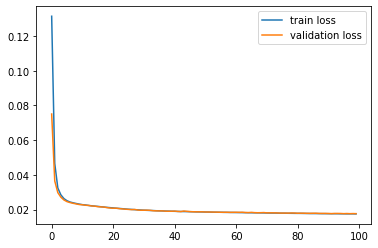

In [ ]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.legend()
plt.show()

# AE fine tuning with classification

Firstly, I freeze the AE parameters exept for the weights and bias in the first convolutional layer of the encoder, and the ones of the last convolutional layer of the decoder. Then, I train them with a classifier (the same as HW1).

In [ ]:
#params

encoded_space_dim = trial.params['encoded_space_dim']
lr = trial.params['lr']
wd = trial.params['wd']

In [ ]:
### Initialize the two networks 

encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

In [ ]:
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in encoder.named_parameters():
    print(param_name)
    print('\tFreezing update')
    param.requires_grad = False  

for param_name, param in decoder.named_parameters():
    print(param_name)
    print('\tFreezing update')
    param.requires_grad = False  

encoder_cnn.0.weight
	Freezing update
encoder_cnn.0.bias
	Freezing update
encoder_cnn.2.weight
	Freezing update
encoder_cnn.2.bias
	Freezing update
encoder_cnn.4.weight
	Freezing update
encoder_cnn.4.bias
	Freezing update
encoder_lin.0.weight
	Freezing update
encoder_lin.0.bias
	Freezing update
encoder_lin.2.weight
	Freezing update
encoder_lin.2.bias
	Freezing update
decoder_lin.0.weight
	Freezing update
decoder_lin.0.bias
	Freezing update
decoder_lin.2.weight
	Freezing update
decoder_lin.2.bias
	Freezing update
decoder_conv.0.weight
	Freezing update
decoder_conv.0.bias
	Freezing update
decoder_conv.2.weight
	Freezing update
decoder_conv.2.bias
	Freezing update
decoder_conv.4.weight
	Freezing update
decoder_conv.4.bias
	Freezing update


In [ ]:
# Allow the training of one conv of both encoder and dec oder

for param in encoder.encoder_cnn[0].parameters():
    param.requires_grad = True 
for param in decoder.decoder_conv[4].parameters():
    param.requires_grad = True 

In [ ]:
# Check if correct
for param_name, param in encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

encoder_cnn.0.weight 	- requires_grad=True
encoder_cnn.0.bias 	- requires_grad=True
encoder_cnn.2.weight 	- requires_grad=False
encoder_cnn.2.bias 	- requires_grad=False
encoder_cnn.4.weight 	- requires_grad=False
encoder_cnn.4.bias 	- requires_grad=False
encoder_lin.0.weight 	- requires_grad=False
encoder_lin.0.bias 	- requires_grad=False
encoder_lin.2.weight 	- requires_grad=False
encoder_lin.2.bias 	- requires_grad=False


In [ ]:
# Check if correct
for param_name, param in decoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

decoder_lin.0.weight 	- requires_grad=False
decoder_lin.0.bias 	- requires_grad=False
decoder_lin.2.weight 	- requires_grad=False
decoder_lin.2.bias 	- requires_grad=False
decoder_conv.0.weight 	- requires_grad=False
decoder_conv.0.bias 	- requires_grad=False
decoder_conv.2.weight 	- requires_grad=False
decoder_conv.2.bias 	- requires_grad=False
decoder_conv.4.weight 	- requires_grad=True
decoder_conv.4.bias 	- requires_grad=True


In [ ]:
class Net_conv(nn.Module):#the same as HW1
  def __init__(self, Nh1=64, Nh2=64, p_drop=0, No=10):

    super(Net_conv,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

    self.fc1=nn.Linear(7*7*32,Nh1)
    self.fc2=nn.Linear(Nh1,Nh2)
    self.out=nn.Linear(Nh2,No)
    self.act=nn.ReLU()
    self.dropout=nn.Dropout(p_drop)

  def forward(self,x):
    x=self.act(self.pool(self.conv1(x)))
    x=self.act(self.pool(self.dropout(self.conv2(x))))
    x=x.view(-1,7*7*32)
    x=self.dropout(x)
    x=self.act(self.dropout(self.fc1(x)))
    x=self.act(self.fc2(x))
    x=torch.softmax(self.out(x), dim=-1)
    return x

In [ ]:
net = Net_conv()

## Training (Fine tuning AE)

In [ ]:
### Define the loss function
loss_fn = nn.CrossEntropyLoss()

### Define an optimizer 

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()},
    {'params': net.parameters()}
]
#optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5) 

if trial.params['optimizer'] == "Adam":
  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=wd)
elif trial.params['optimizer'] == "RMSprop":
  optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=wd)
elif trial.params['optimizer'] == "SGD":
  optim = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=wd)
else: print('Error in optimizer!')


# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
net.to(device)

Selected device: cuda


Net_conv2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0, inplace=False)
)

In [ ]:
### Training function
def train_epoch_ft(encoder, decoder, net, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    net.train()

    conc_out = []
    conc_label = []

    # Iterate the dataloader
    for image_batch, label_batch in dataloader:
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Classification
        out_data = net(decoded_data)
        #print(image_batch.shape,decoded_data.shape)

        #out_data = net(image_batch)
        #print(decoded_data.cpu())
        # Evaluate loss
        loss = loss_fn(out_data, label_batch) #SUPERVISED!
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append the network output and the original image to the lists
        conc_out.append(out_data.cpu())
        conc_label.append(label_batch.cpu())

    # Create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label) 
    # Evaluate global loss
    train_loss = loss_fn(conc_out, conc_label)

    return train_loss.data


In [ ]:
### Testing function
def test_epoch_ft(encoder, decoder, net, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    net.eval()

    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Classification
            out_data = net(decoded_data)
            

            # Append the network output and the original image to the lists
            conc_out.append(out_data.cpu())
            conc_label.append(label_batch.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return conc_out, conc_label, val_loss.data

In [ ]:
### Training cycle

def training_func_ft(encoder,decoder,net,device,train_dataloader,val_dataloader,
                     parameters,save_state=True):
  
  num_epochs = parameters['epochs']
  optim = parameters['optim']
  train_losses = []
  val_losses = []

  for epoch in tqdm(range(num_epochs)):
    
      ### Training (use the training function)
      train_epoch_ft(encoder=encoder,
                     decoder=decoder,
                     net=net,
                     device=device,
                     dataloader=train_dataloader,
                     loss_fn=parameters['loss'], 
                     optimizer=optim)
      

      _,_,train_loss = test_epoch_ft(encoder=encoder,
                     decoder=decoder,
                     net=net,
                     device=device,
                     dataloader=train_dataloader,
                     loss_fn=parameters['loss'])
      
    
      train_losses.append(train_loss)

      ### Validation  (use the testing function)
      _,_,val_loss = test_epoch_ft(encoder=encoder,
                     decoder=decoder,
                     net=net,
                     device=device,
                     dataloader=val_dataloader,
                     loss_fn=parameters['loss'])
      
      val_losses.append(val_loss)

      ### Save model parameters
      if (save_state):
        torch.save(encoder.state_dict(), 'finetuned_model_enc.pth')
        torch.save(decoder.state_dict(), 'finetuned_model_dec.pth')
        torch.save(net.state_dict(), 'finetuned_model_net.pth')

  return train_losses, val_losses

In [ ]:
parameters = {'epochs': 40,
              'optim': optim,
              'loss': loss_fn}

In [ ]:
train_loss, val_loss = training_func_ft(encoder,decoder,net,device,train_dataloader,validation_dataloader, parameters)

100%|██████████| 40/40 [06:47<00:00, 10.18s/it]


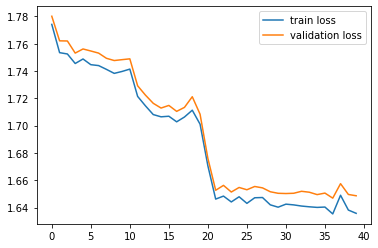

In [ ]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.legend()
plt.show()

In [ ]:
### Test loss
encoder.load_state_dict(torch.load('finetuned_model_enc.pth'))
decoder.load_state_dict(torch.load('finetuned_model_dec.pth'))
net.load_state_dict(torch.load('finetuned_model_net.pth'))


test_outputs, test_labels, test_loss = test_epoch_ft(encoder=encoder,
                                                     decoder=decoder,
                                                     net=net,
                                                     device=device,
                                                     dataloader=test_dataloader,
                                                     loss_fn=nn.CrossEntropyLoss())
# Print Test loss
print(f"\n\nTEST LOSS : {test_loss}")



TEST LOSS : 1.657164216041565


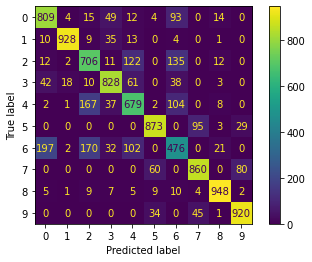

In [ ]:
### Confusion matrix


# Predicted labels
y_true = test_labels.cpu().data.numpy()
y_pred = test_outputs.cpu().argmax(dim=1).numpy()

# Evaluate confusion matrix
cm = confusion_matrix(y_true, y_pred)

ConfusionMatrixDisplay(cm).plot()
plt.show()

In [ ]:
#total accuracy
accuracy_score(y_true, y_pred)

0.8027

The confusion matrix and the accuracy are worse than the one of the first homework. I think that training the AE longer can make better performances.

# Latent space structure: PCA and t-SNE
 Using PCA and t_SNE for latent space reduction.

In [ ]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:07<00:00, 1363.44it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,label
0,2.394476,-0.218901,34.663265,-44.264877,28.246290,9
1,-83.121071,-34.617279,34.050037,46.106094,-88.521576,2
2,-38.316307,3.309540,-75.232956,-7.716523,-12.298801,1
3,-19.301949,19.433252,-53.745464,-1.502627,-6.987654,1
4,-43.430099,-2.411282,26.499371,38.903114,-50.365959,6
...,...,...,...,...,...,...
9995,-30.400993,-22.177448,52.458183,-60.921329,32.301853,9
9996,-9.372061,12.861543,-34.600208,9.366787,-5.137501,1
9997,-9.952356,65.778938,12.201635,-12.997409,-8.628745,8
9998,-21.406563,25.765755,-55.321678,11.464722,11.198581,1


In [ ]:
encoded_samples.max()

Enc. Variable 0     51.950432
Enc. Variable 1     94.399643
Enc. Variable 2    126.942024
Enc. Variable 3    101.524597
Enc. Variable 4     58.638260
label                9.000000
dtype: float64

In [ ]:
encoded_samples.min()

Enc. Variable 0   -111.872887
Enc. Variable 1    -73.895721
Enc. Variable 2    -86.447510
Enc. Variable 3    -98.479431
Enc. Variable 4   -133.309494
label                0.000000
dtype: float64

## PCA

In [ ]:
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pd.DataFrame(pca.fit_transform(encoded_samples))

In [ ]:
px.scatter(encoded_samples_reduced_PCA,x=0,y=1, color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

The PCA shows how the latent space contains the informations necessary to correctly group the images into the different classes. The AE is able to identify which features characterize the most each input image, causing a grouping of the similar images.

## t-SNE

In [ ]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = pd.DataFrame(tsne.fit_transform(encoded_samples))


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
px.scatter(encoded_samples_reduced_TSNE,x=0,y=1, color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

t_SNE performs worse than PCA, but is possible to distinguish also here the different classes.

## New samples generator

Here I try to generate new samples. Some of them are clearly belonging to some classes, others no. This is because I randomly choose the 5-dimensional arrays that represent a point in the latent space, but this space can be not continuous: it is possible to choose a point in an empty region of that space, that has no meaning for the decoder.

In [ ]:
np.random.seed(1)
def sample_generator(encoded_space_dim, number):

  fig, axs = plt.subplots(number, 6, figsize=(12,number*2))

  for i in range(number):
    for j in range(6):
      sample = np.random.randint(low=-60, high=60 , size= encoded_space_dim)
      encoded_value = torch.tensor(sample).float().unsqueeze(0).to(device)

      # Decode sample
      decoder.eval()
      with torch.no_grad():
          generated_img  = decoder(encoded_value)

      axs[i,j].imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')

  plt.show()

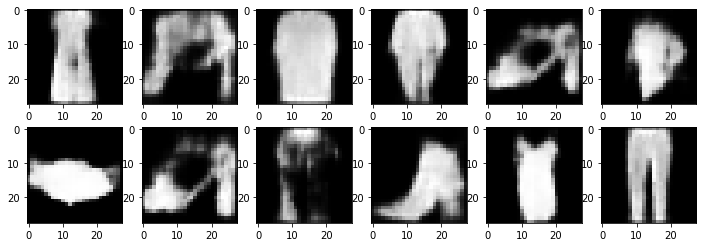

In [ ]:
sample_generator(encoded_space_dim,2)

# Variational AutoEncoder



In [ ]:
class VariationalEncoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.linear1 = nn.Linear(in_features=32*3*3, out_features=64)
        self.linear2 = nn.Linear(64, latent_dims)
        self.linear3 = nn.Linear(64, latent_dims)

        self.act = nn.ReLU()

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # Apply linear layers
        x = self.act(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
torch.manual_seed(4)

d = 4
vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3
wd = 1e-5

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=wd)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=288, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=4, bias=True)
    (linear3): Linear(in_features=64, out_features=4, bias=True)
    (act): ReLU()
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(

## Training

In [ ]:
### Training function
def train_epoch_vae(vae, device, dataloader, optimizer):
    # Set train mode
    vae.train()
    train_loss = 0.0

    # Iterate the dataloader
    for image_batch, _ in dataloader:
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Out data
        out_data = vae(image_batch)
        # Evaluate loss
        loss = ((out_data - image_batch)**2).sum() + vae.encoder.kl#the second term is KL divergence
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #partial loss
        train_loss += loss.item()
        
    return train_loss / len(dataloader.dataset) 


In [ ]:
### Testing function
def test_epoch_vae(vae, device, dataloader):
    # Set evaluation mode
    vae.eval()
    test_loss = 0.0
   
    with torch.no_grad(): # No need to track the gradients

        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            #out data
            out_data = vae(image_batch)
            #loss
            loss = ((out_data - image_batch)**2).sum() + vae.encoder.kl

            #partial loss
            test_loss += loss.item()
        
    return test_loss / len(dataloader.dataset) 

In [ ]:
### Training loop

def training_vae(vae,device,train_dataloader,test_dataloader,parameters):

  num_epochs = parameters['epochs']
  optim = parameters['optim']
  train_loss_tot = []
  val_loss_tot = []
  for epoch in tqdm(range(num_epochs)):
    
      ### Training (use the training function)
      train_loss = train_epoch_vae(
          vae=vae, 
          device=device, 
          dataloader=train_dataloader, 
          loss_fn=parameters['loss'], 
          optimizer=optim)
      
      ### Validation  (use the testing function)
      val_loss = test_epoch_vae(
          vae=vae, 
          device=device, 
          dataloader=test_dataloader, 
          loss_fn=parameters['loss'])

      train_loss_tot.append(train_loss)
      val_loss_tot.append(val_loss)

  
  return train_loss_tot, val_loss_tot



In [ ]:
parameters = {'epochs': 20,
              'optim': optim,
              'loss': loss_fn}

In [ ]:
train_loss_vae, val_loss_vae = training_vae(vae,device,train_dataloader,validation_dataloader, parameters)

100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


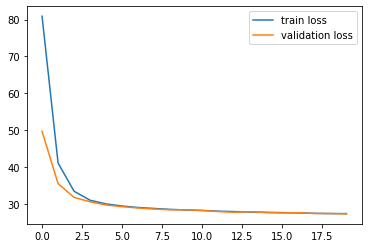

In [ ]:
plt.plot(train_loss_vae,label='train loss')
plt.plot(val_loss_vae,label='validation loss')
plt.legend()
plt.show()

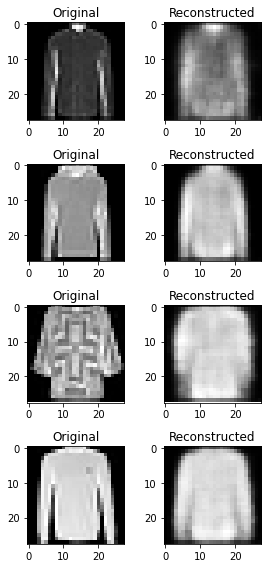

In [ ]:
## Examples of image reconstruction
fig, axs = plt.subplots(4, 2, figsize=(4,8))

for i in range(4):
  a=random.randint(1,10001)
  img, label = test_dataset[a]

  out_img  = vae(img.unsqueeze(0).to(device))
  

  axs[i,0].imshow(np.array(img[0]), cmap='gist_gray')
  axs[i,0].set_title('Original')
  axs[i,1].imshow(out_img.squeeze().cpu().detach().numpy(), cmap='gist_gray')
  axs[i,1].set_title('Reconstructed')

plt.tight_layout()